<font color=blue, size="6"> **Análise de Sentimentos: <br> Resenha de Filmes**</font>

![](https://machinelearningknowledge.ai/ezoimgfmt/953894.smushcdn.com/2611031/wp-content/uploads/2021/05/text_preprocessing-696x696.png?lossy=0&strip=1&webp=1&ezimgfmt=ng:webp/ngcb1)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer

from wordcloud import WordCloud
import spacy


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sarah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Conhecendo os dados

In [2]:
df = pd.read_csv ('imdb-reviews-pt-br.csv')
df.head(3)

,id,text_en,text_pt,sentiment
0,1,"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costners character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks hes better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutchers ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.","Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. A maioria de nós tem fantasmas no armário, e o personagem Costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. O personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, Ashton Kutcher. O problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, quando estamos bem além do meio do caminho, Costner nos conta sobre os fantasmas dos Kutchers. Somos informados de por que Kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. Nenhuma mágica aqui, era tudo que eu podia fazer para não desligar uma hora.",neg
1,2,"This is an example of why the majority of action films are the same. Generic and boring, theres really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and Ice Cube, whove each proven many times over that they are capable of acting, and acting well. Dont bother with this one, go see New Jack City, Ricochet or watch New York Undercover for Ice-T, or Boyz n the Hood, Higher Learning or Friday for Ice Cube and see the real deal. Ice-Ts horribly cliched dialogue alone makes this film grate at the teeth, and Im still wondering what the heck Bill Paxton was doing in this film? And why the heck does he always play the exact same character? From Aliens onward, every film Ive seen with Bill Paxton has him playing the exact same irritating character, and at least in Aliens his character died, which made it somewhat gratifying...Overall, this is second-rate action trash. There are countless better films to see, and if you really want to see this one, watch Judgement Night, which is practically a carbon copy but has better acting and a better script. The only thing that made this at all worth watching was a decent hand on the camera - the cinematography was almost refreshing, which comes close to making up for the horrible film itself - but not quite. 4/10.","Este é um exemplo do motivo pelo qual a maioria dos filmes de ação são os mesmos. Genérico e chato, não há nada que valha a pena assistir aqui. Um completo desperdício dos talentos de Ice-T e Cubo de Gelo que foram mal aproveitados, cada um comprovando que são capazes de atuar e agir bem. Não se incomode com este, vá ver New Jack City, Ricochet ou assistir New York Undercover para Ice-T, ou Boyz no Hood, Higher Learning ou Friday for Ice Cube e ver o negócio real. Ice-Ts horrivelmente clichê diálogo sozinho faz este filme ralar os dentes, e eu ainda estou me perguntando o que diabos Bill Paxton estava fazendo neste filme? E por que diabos ele sempre interpreta exatamente o mesmo personagem? Dos extraterrestres em diante, todos os filmes que eu vi com Bill Pa

In [3]:
df.shape

(49459, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49459 entries, 0 to 49458
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         49459 non-null  int64 
 1   text_en    49459 non-null  object
 2   text_pt    49459 non-null  object
 3   sentiment  49459 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [5]:
df.sentiment.value_counts()

neg    24765
pos    24694
Name: sentiment, dtype: int64

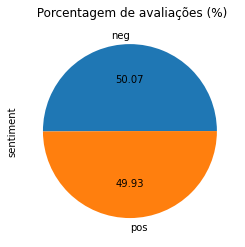

In [6]:
fig = df.sentiment.value_counts().plot.pie(autopct='%.2f')
_ = fig.set_title (" Porcentagem de avaliações (%)")

 Verificou-se que:
 - não existem dados nulo
 - ao todo são 49.459 resenhas
 - a classificação das opiniões são entre positivas ou negativas
 - que os dados estão bem balançeados, sendo 50,07% de opiniões negativas e 49,93% positivas.

In [7]:
# criando uma classificação 0 e 1

classification = np.where(df['sentiment'] == 'neg', 0, 1)
classification

array([0, 0, 0, ..., 1, 1, 1])

In [8]:
df['classification'] = classification

In [9]:
df.sample(5)

id                                            text_en  \
31295  31297  I used to LOVE this movie as a kid but, seeing...   
31122  31124  The film gives a rather condensed version of w...   
19678  19680  This film was great! I love the way it mixes d...   
21050  21052  A gruelling watch, but one of Bergmans finest ...   
19162  19164  You dont have to be a fan of the cartoon show ...   

                                                 text_pt sentiment  \
31295  Eu costumava amar este filme quando criança, m...       neg   
31122  O filme dá uma versão bastante condensada do q...       neg   
19678  Este filme foi ótimo! Eu amo o jeito que mistu...       pos   
21050  Um relógio cansativo, mas um dos melhores film...       pos   
19162  Você não tem que ser um fã do desenho animado ...       pos   

       classification  
31295               0  
31122               0  
19678               1  
21050               1  
19162               1

In [10]:
# removendo as colunas de revisão em ing e de sentimentos 

df = df.drop(columns = ['id', 'text_en', 'sentiment'])

In [11]:
df.head(3)

,text_pt,classification
0,"Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. A maioria de nós tem fantasmas no armário, e o personagem Costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. O personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, Ashton Kutcher. O problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, quando estamos bem além do meio do caminho, Costner nos conta sobre os fantasmas dos Kutchers. Somos informados de por que Kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. Nenhuma mágica aqui, era tudo que eu podia fazer para não desligar uma hora.",0
1,"Este é um exemplo do motivo pelo qual a maioria dos filmes de ação são os mesmos. Genérico e chato, não há nada que valha a pena assistir aqui. Um completo desperdício dos talentos de Ice-T e Cubo de Gelo que foram mal aproveitados, cada um comprovando que são capazes de atuar e agir bem. Não se incomode com este, vá ver New Jack City, Ricochet ou assistir New York Undercover para Ice-T, ou Boyz no Hood, Higher Learning ou Friday for Ice Cube e ver o negócio real. Ice-Ts horrivelmente clichê diálogo sozinho faz este filme ralar os dentes, e eu ainda estou me perguntando o que diabos Bill Paxton estava fazendo neste filme? E por que diabos ele sempre interpreta exatamente o mesmo personagem? Dos extraterrestres em diante, todos os filmes que eu vi com Bill Paxton o fizeram interpretar exatamente o mesmo personagem irritante, e pelo menos em Aliens seu personagem morreu, o que o tornou um pouco gratificante ... No geral, esse é lixo de ação de segunda classe. Existem incontáveis ​​filmes melhores para ver, e se você realmente quiser ver esse filme, assista a Judgment Night, que é praticamente uma cópia carbono, mas tem melhor atuação e um roteiro melhor. A única coisa que fez isso valer a pena assistir foi uma mão decente na câmera - a cinematografia era quase refrescante, o que chega perto de compensar o horrível filme em si - mas não é bem assim. 4/10",0
2,"Primeiro de tudo eu odeio esses raps imbecis, que não poderiam agir se tivessem uma arma pressionada contra suas testas. Tudo o que eles fazem é amaldiçoar e atirar um no outro e agir como uma versão clichê de gangsters. O filme não leva mais de cinco minutos para explicar o que está acontecendo antes que já estivessem no armazém. Não há um único personagem simpático nesse filme, com exceção do sem-teto, que também é o único com metade do cérebro. William Paxton e William Sadler são ambos ""hill billies"" e Sadler é tão vilão quanto os gângsteres. Eu não gostava dele desde o começo. O filme está cheio de violência sem sentido e especialidade de Walter Hills: pessoas caindo de janelas com vidros voando por toda parte. Não há praticamente nenhum enredo e é um grande problema quando você torce por ninguém. Todo mundo morre, exceto Paxton e o sem-teto e todos recebem o que merecem. Os dois únicos negros que podem atuar são o sem-teto e o viciado, mas são atores de profissão, não irritantes rappers feios. Fique longe dessa porcaria. e observe 48 horas 1 e 2 em vez disso. No mínimo, eles têm personagens de que você gosta, senso de humor e nada além de atores reais no elenco.",0


# Pré-Processamento do texto

In [12]:
# criando uma nuvem de palvaras com todas as resenhas

def word_cloud (df, col_text):

    # juntando todas as palavras de todos as linhas 
    todos_palavras = ' '.join([texto for texto in df[col_text]])

    # criando a nuvem de plavavras
    nuvem_palavras = WordCloud(width = 800, height = 500, max_font_size = 110,
                              collocations = False).generate(todos_palavras)

    #exibindo a nuvem de plavaras
    plt.figure(figsize= (10, 7))
    plt.imshow(nuvem_palavras, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()


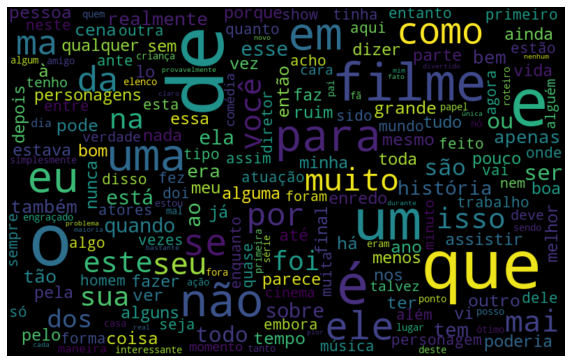

In [13]:
word_cloud (df, "text_pt")

É possivel notar a necessidade de uma limpeza do texto, como a remoção de stopword. Além disso, é necessário outros processamento como  remoção de pontuação, números, espaços extras, entre outros.

Esse tratamento será realziado antes da divisão dos dados entre treino e teste.

### Limpeza dos dados

Para a limpeza do dados, inicialmente foi crida uma função para:
- deixar todas as letras em minúscula
- tokenizar o texto
- remoção de pontuação
- remoção de caracteres especiais

In [14]:
def clean_text (df, col_text):
    dados = df[col_text] # texto para a limpeza

    # letras em minusculas
    text_lower = [word.lower() for word in dados]

    # tokenizando o texto utilizando o método RegexpTokenizer (), 
    # pois com ele já é retirada a pontuação, por meio de regex
    # https://machinelearningknowledge.ai/nltk-tokenizer-tutorial-with-word_tokenize-sent_tokenize-whitespacetokenizer-wordpuncttokenizer/

    frase_processada = []
    token = RegexpTokenizer(r"\w+") #\w = matches any word character (equivalent to [a-zA-Z0-9_])

    for resenha in text_lower:
        nova_frase = []
        word_token = token.tokenize(resenha)

        # remoção de stopwords
        stop_words = nltk.corpus.stopwords.words("portuguese")
        for word in word_token:
            if word  not in stop_words and len(word)>2:
                nova_frase.append(word)
        frase_processada.append(' '.join(nova_frase))
        

    return frase_processada



In [15]:
txt_clean= clean_text (df, "text_pt")
df['text_clean'] = txt_clean

In [16]:
df.head(3)

,text_pt,classification,text_clean
0,"Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. A maioria de nós tem fantasmas no armário, e o personagem Costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. O personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, Ashton Kutcher. O problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, quando estamos bem além do meio do caminho, Costner nos conta sobre os fantasmas dos Kutchers. Somos informados de por que Kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. Nenhuma mágica aqui, era tudo que eu podia fazer para não desligar uma hora.",0,vez costner arrumou filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importei nenhum personagens maioria fantasmas armário personagem costers realizado logo início esquecido tarde importava personagem deveríamos importar arrogante superconfiante ashton kutcher problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armário desordenado único obstáculo parece estar vencendo costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informados kutcher levado ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo podia fazer desligar hora
1,"Este é um exemplo do motivo pelo qual a maioria dos filmes de ação são os mesmos. Genérico e chato, não há nada que valha a pena assistir aqui. Um completo desperdício dos talentos de Ice-T e Cubo de Gelo que foram mal aproveitados, cada um comprovando que são capazes de atuar e agir bem. Não se incomode com este, vá ver New Jack City, Ricochet ou assistir New York Undercover para Ice-T, ou Boyz no Hood, Higher Learning ou Friday for Ice Cube e ver o negócio real. Ice-Ts horrivelmente clichê diálogo sozinho faz este filme ralar os dentes, e eu ainda estou me perguntando o que diabos Bill Paxton estava fazendo neste filme? E por que diabos ele sempre interpreta exatamente o mesmo personagem? Dos extraterrestres em diante, todos os filmes que eu vi com Bill Paxton o fizeram interpretar exatamente o mesmo personagem irritante, e pelo menos em Aliens seu personagem morreu, o que o tornou um pouco gratificante ... No geral, esse é lixo de ação de segunda classe. Existem incontáveis ​​filmes melhores para ver, e se você realmente quiser ver esse filme, assista a Judgment Night, que é praticamente uma cópia carbono, mas tem melhor atuação e um roteiro melhor. A única coisa que fez isso valer a pena assistir foi uma mão decente na câmera - a cinematografia era quase refrescante, o que chega perto de compensar o horrível filme em si - mas não é bem assim. 4/10",0,exemplo motivo maioria filmes ação mesmos genérico chato nada valha pena assistir aqui completo desperdício talentos ice cubo gelo mal aproveitados cada comprovando capazes atuar agir bem incomode ver new jack city ricochet assistir new york undercover ice boyz hood higher learning friday ice cube ver negócio real ice horrivelmente clichê diálogo sozinho faz filme ralar dentes ainda perguntando diabos bill paxton fazendo neste filme diabos sempre interpreta exatamente personagem extraterrestres diante todos filmes bill paxton fizeram interpretar exatamente personagem irritante menos aliens personagem morreu tornou pouco gratificante geral lixo ação segunda classe existem incontáveis filmes melhores ver realmente quiser ver filme assista judgment night praticamente cópia carbono melhor atuação roteiro melhor única coisa fez valer pena assistir mão decente câmera cinematografia quase refrescante chega perto compensar horrível filme bem assim
2,"Prime

In [30]:
def word_cloud_sentiment (dados, text_col, col_classification, sentiment):
    text_sentimento = dados[dados[col_classification]==sentiment]
    todas_as_palavra = ' '.join([texto for texto in text_sentimento[text_col]])

    wordcloud = WordCloud (width = 800, height = 500,
                           max_font_size = 110, 
                           collocations = False).generate(todas_as_palavra)
    
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show() 
    
    

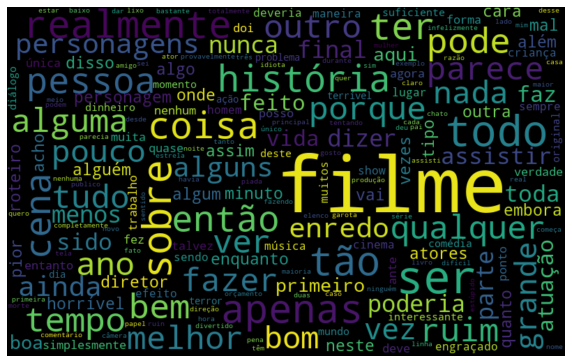

In [18]:
# gerando uma nuvem de palvaras para as resenhas negativas
word_cloud_sentiment (df, "text_clean", "classification" , sentiment = 0)

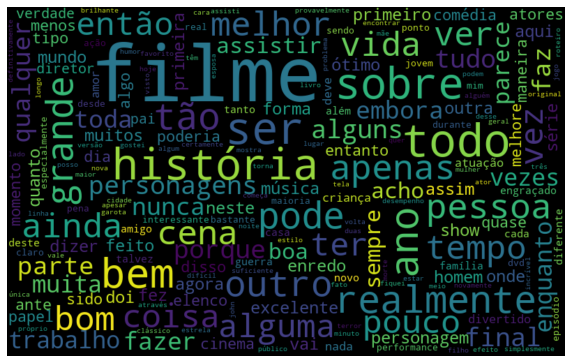

In [19]:
# gerando uma nuvem de palvaras para as resenhas positivas
word_cloud_sentiment (df, "text_clean", "classification" , sentiment = 1)

In [35]:
def freq_words(texto, coluna_texto, quantidade):
    # tokenizando as palvras por espaço em branco
    token_espaco = WhitespaceTokenizer()
    
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    
    frequencia = nltk.FreqDist(token_espaco.tokenize(todas_palavras))
    
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                 "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = quantidade)
    
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x= "Palavra", y = "Frequência", color = 'gray')
    ax.set(ylabel = "Contagem")
    plt.show()

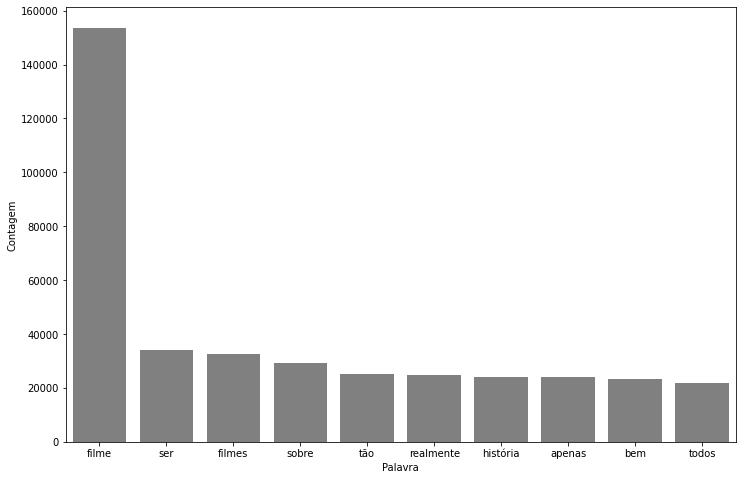

In [21]:
freq_words(df, 'text_clean', 10)

In [22]:
df.to_csv('clean_data.csv', index = False)

Além da limpeza dos dados é possivel aplicar duas técnicas de redução das palavras:
- Stemming
- lemmatization

Para verificar como que aplicação dessas técnicas impactam nos resultados, serão feitos esses processos em separados e juntos.

## Lemmatization

In [23]:
def text_lemma (df_texto):
    nlp = spacy.load('pt_core_news_sm')
    
    doc = nlp(df_texto)
    doc_lematizado = [token.lemma_ if token.pos_ in ('VERB', 'AUX') else str(token) for token in doc]
    return ' '.join(doc_lematizado)

In [24]:
# passando diretamente a nova coluna os dados já tratados, usando  o apply
df['text_lemma'] = df['text_clean'].apply(text_lemma)

In [ ]:
df.head(3)

,text_pt,classification,text_clean,lematized_text
0,"Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. A maioria de nós tem fantasmas no armário, e o personagem Costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. O personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, Ashton Kutcher. O problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, quando estamos bem além do meio do caminho, Costner nos conta sobre os fantasmas dos Kutchers. Somos informados de por que Kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. Nenhuma mágica aqui, era tudo que eu podia fazer para não desligar uma hora.",0,vez costner arrumou filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importei nenhum personagens maioria fantasmas armário personagem costers realizado logo início esquecido tarde importava personagem deveríamos importar arrogante superconfiante ashton kutcher problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armário desordenado único obstáculo parece estar vencendo costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informados kutcher levado ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo podia fazer desligar hora,vez costner arrumar filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importar nenhum personagens maioria fantasmas armário personagem costers realizar logo início esquecido tarde importar personagem dever importar arrogante superconfiante ashton kutcher problema sair garoto pensar melhor qualquer outra pessoa redor mostrar sinais armário desordenar único obstáculo parecer estar vencer costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informar kutcher levar ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo poder fazer desligar hora
1,"Este é um exemplo do motivo pelo qual a maioria dos filmes de ação são os mesmos. Genérico e chato, não há nada que valha a pena assistir aqui. Um completo desperdício dos talentos de Ice-T e Cubo de Gelo que foram mal aproveitados, cada um comprovando que são capazes de atuar e agir bem. Não se incomode com este, vá ver New Jack City, Ricochet ou assistir New York Undercover para Ice-T, ou Boyz no Hood, Higher Learning ou Friday for Ice Cube e ver o negócio real. Ice-Ts horrivelmente clichê diálogo sozinho faz este filme ralar os dentes, e eu ainda estou me perguntando o que diabos Bill Paxton estava fazendo neste filme? E por que diabos ele sempre interpreta exatamente o mesmo personagem? Dos extraterrestres em diante, todos os filmes que eu vi com Bill Paxton o fizeram interpretar exatamente o mesmo personagem irritante, e pelo menos em Aliens seu personagem morreu, o que o tornou um pouco gratificante ... No geral, esse é lixo de ação de segunda classe. Existem incontáveis ​​filmes melhores para ver, e se você realmente quiser ver esse filme, assista a Judgment Night, que é praticamente uma cópia carbono, mas tem melhor atuação e um roteiro melhor. A única coisa que fez isso valer a pena assistir foi uma mão decente na câmera - a cinematografia era quase refrescante, o que chega perto de compensar o horrível filme em si - mas não é bem assim. 4/10",0,exemplo motivo maioria filmes ação mesmos genérico chato nada valha pena assistir aqui completo desperdício talentos ice cubo gelo mal aproveitados cada comprovando capazes atuar agir bem incomode ver new jack city ricochet assistir new york undercover ice boyz hood higher learning friday ice cube ver negócio real ic

Agora podemos verificar como que estão as nuvens de palavras e também a frequência das palavras

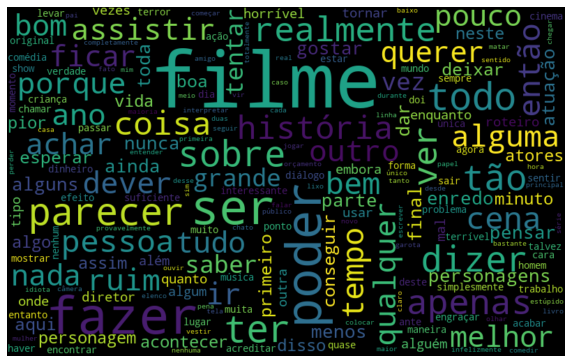

In [ ]:
# gerando uma nuvem de palvaras para as resenhas negativa dos dados lematizado
word_cloud_sentiment (df, "lematized_text", "classification" , sentiment = 0)

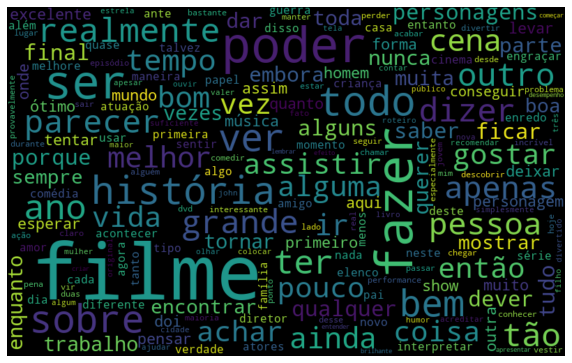

In [ ]:
# gerando uma nuvem de palvaras para as resenhas positivas dos dados lematizado
word_cloud_sentiment (df, "lematized_text", "classification" , sentiment = 1)

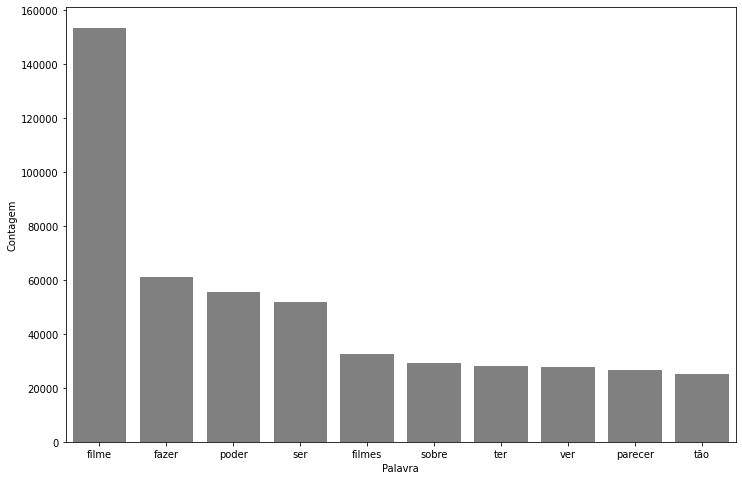

In [36]:
freq_words(df, 'text_lemma', 10)

In [ ]:
df.to_csv('clean_data_lematized.csv', index = False)

## Stemming

In [2]:
df = pd.read_csv ('clean_data_lematized.csv')
df.head(1)

,text_pt,classification,text_clean,lematized_text
0,"Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. A maioria de nós tem fantasmas no armário, e o personagem Costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. O personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, Ashton Kutcher. O problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, quando estamos bem além do meio do caminho, Costner nos conta sobre os fantasmas dos Kutchers. Somos informados de por que Kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. Nenhuma mágica aqui, era tudo que eu podia fazer para não desligar uma hora.",0,vez costner arrumou filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importei nenhum personagens maioria fantasmas armário personagem costers realizado logo início esquecido tarde importava personagem deveríamos importar arrogante superconfiante ashton kutcher problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armário desordenado único obstáculo parece estar vencendo costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informados kutcher levado ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo podia fazer desligar hora,vez costner arrumar filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importar nenhum personagens maioria fantasmas armário personagem costers realizar logo início esquecido tarde importar personagem dever importar arrogante superconfiante ashton kutcher problema sair garoto pensar melhor qualquer outra pessoa redor mostrar sinais armário desordenar único obstáculo parecer estar vencer costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informar kutcher levar ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo poder fazer desligar hora


In [16]:
frase_processada = []
token = WhitespaceTokenizer()

for resenha in df['text_clean']:
    nova_frase = []
    word_token = token.tokenize(resenha)

    # stemmetization
    st = SnowballStemmer("portuguese")
    for word in word_token:
        nova_frase.append(st.stem(word))
    frase_processada.append(' '.join(nova_frase))

In [17]:
df ['text_stemm2'] = frase_processada

In [ ]:
df.head(3)

 Arrumando o nome das colunas e deletando os teste criados 

In [20]:
import mitosheet
mitosheet.sheet(df, view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-2d01b669-908b-4abb-b0cd-5ff4b8e3fab5", "code": {"imports…

In [22]:
from mitosheet import *; register_analysis('UUID-2d01b669-908b-4abb-b0cd-5ff4b8e3fab5')

# Renamed lematized_text to text_lemma in df
df.rename(columns={'lematized_text': 'text_lemma'}, inplace=True)

# Deleted column text_stemm from df
df.drop(['text_stemm'], axis=1, inplace=True)

# Renamed text_stemm2 to text_stemm in df
df.rename(columns={'text_stemm2': 'text_stemm'}, inplace=True)


In [23]:
df.head(3)

,text_pt,classification,text_clean,text_lemma,text_stemm
0,"Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. A maioria de nós tem fantasmas no armário, e o personagem Costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. O personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, Ashton Kutcher. O problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, quando estamos bem além do meio do caminho, Costner nos conta sobre os fantasmas dos Kutchers. Somos informados de por que Kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. Nenhuma mágica aqui, era tudo que eu podia fazer para não desligar uma hora.",0,vez costner arrumou filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importei nenhum personagens maioria fantasmas armário personagem costers realizado logo início esquecido tarde importava personagem deveríamos importar arrogante superconfiante ashton kutcher problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armário desordenado único obstáculo parece estar vencendo costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informados kutcher levado ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo podia fazer desligar hora,vez costner arrumar filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importar nenhum personagens maioria fantasmas armário personagem costers realizar logo início esquecido tarde importar personagem dever importar arrogante superconfiante ashton kutcher problema sair garoto pensar melhor qualquer outra pessoa redor mostrar sinais armário desordenar único obstáculo parecer estar vencer costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informar kutcher levar ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo poder fazer desligar hora,vez costn arrum film temp necessári além terrív sequênc resgat mar qua pouc simples import nenhum personagens maior fantasm armári personag costers realiz log iníci esquec tard import personag dev import arrog superconfi ashton kutch problem sai garot pens melhor qualqu outr pesso redor mostr sin armári desorden únic obstácul parec estar venc costn final bem além mei caminh costn cont sobr fantasm kutchers inform kutch lev ser melhor pressent pressági anterior nenhum mágic aqu tud pod faz deslig hor
1,"Este é um exemplo do motivo pelo qual a maioria dos filmes de ação são os mesmos. Genérico e chato, não há nada que valha a pena assistir aqui. Um completo desperdício dos talentos de Ice-T e Cubo de Gelo que foram mal aproveitados, cada um comprovando que são capazes de atuar e agir bem. Não se incomode com este, vá ver New Jack City, Ricochet ou assistir New York Undercover para Ice-T, ou Boyz no Hood, Higher Learning ou Friday for Ice Cube e ver o negócio real. Ice-Ts horrivelmente clichê diálogo sozinho faz este filme ralar os dentes, e eu ainda estou me perguntando o que diabos Bill Paxton estava fazendo neste filme? E por que diabos ele sempre interpreta exatamente o mesmo personagem? Dos extraterrestres em diante, todos os filmes que eu vi com Bill Paxton o fizeram interpretar exatamente o mesmo personagem irritante, e pelo menos em Aliens seu personagem morreu, o que o tornou um pouco gratificante ... No geral, esse é lixo de ação de segunda classe. Existem incontáveis ​​filmes melhores para ver, e se você realmente quiser ver esse filme, assista a Judgment Night, que é praticamente uma cópia carbono, mas tem melhor atuação e um roteiro melhor. A única cois

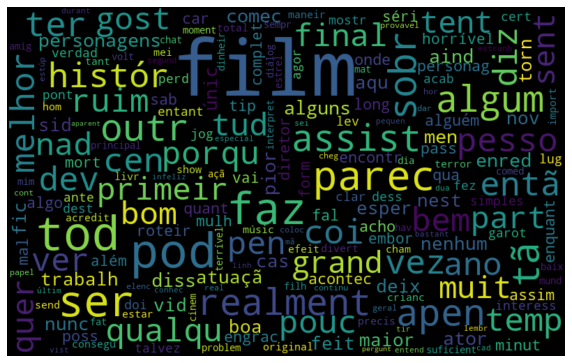

In [37]:
# gerando uma nuvem de palvaras para as resenhas negativas dos dados stemetizado
word_cloud_sentiment (df, "text_stemm", "classification" , sentiment = 0)

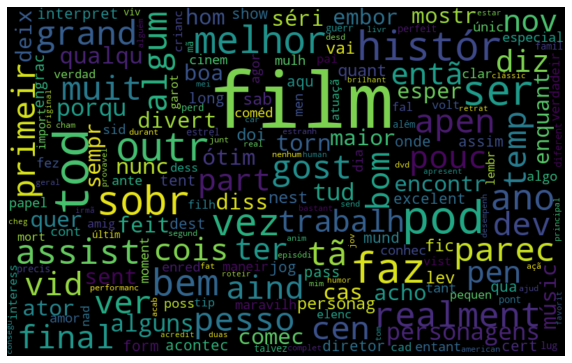

In [38]:
# gerando uma nuvem de palvaras para as resenhas positivas dos dados stemetizado
word_cloud_sentiment (df, "text_stemm", "classification" , sentiment = 1)

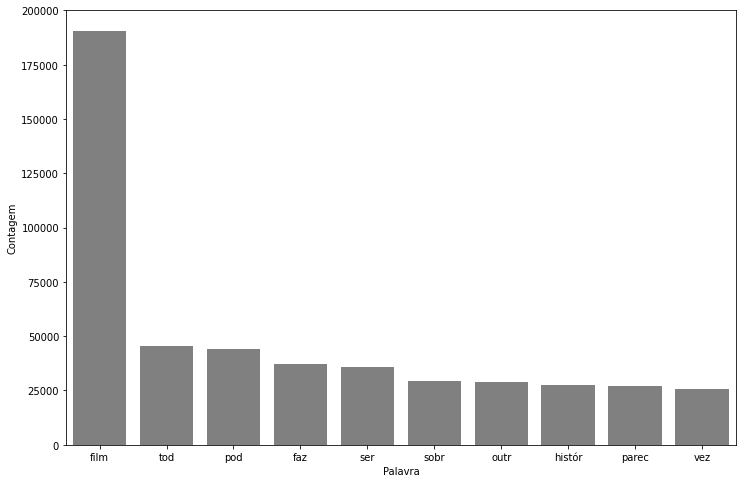

In [39]:
freq_words(df, 'text_stemm', 10)

In [24]:
df.to_csv('clean_data_stemetized', index = False)

## Lemmatization + Stemming

Para ter uma base com lemma e stemm, vou utilizar a coluna já lematizada e fazer a stemitazação nela.

In [25]:
frase_processada = []
token = WhitespaceTokenizer()

for resenha in df['text_lemma']:
    nova_frase = []
    word_token = token.tokenize(resenha)

    # stemmetization
    st = SnowballStemmer("portuguese")
    for word in word_token:
        nova_frase.append(st.stem(word))
    frase_processada.append(' '.join(nova_frase))

In [26]:
df ['text_lemma_e_stemm'] = frase_processada

In [27]:
df.head(3)

,text_pt,classification,text_clean,text_lemma,text_stemm,text_lemma_e_stemm
0,"Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. A maioria de nós tem fantasmas no armário, e o personagem Costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. O personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, Ashton Kutcher. O problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, quando estamos bem além do meio do caminho, Costner nos conta sobre os fantasmas dos Kutchers. Somos informados de por que Kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. Nenhuma mágica aqui, era tudo que eu podia fazer para não desligar uma hora.",0,vez costner arrumou filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importei nenhum personagens maioria fantasmas armário personagem costers realizado logo início esquecido tarde importava personagem deveríamos importar arrogante superconfiante ashton kutcher problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armário desordenado único obstáculo parece estar vencendo costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informados kutcher levado ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo podia fazer desligar hora,vez costner arrumar filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importar nenhum personagens maioria fantasmas armário personagem costers realizar logo início esquecido tarde importar personagem dever importar arrogante superconfiante ashton kutcher problema sair garoto pensar melhor qualquer outra pessoa redor mostrar sinais armário desordenar único obstáculo parecer estar vencer costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informar kutcher levar ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo poder fazer desligar hora,vez costn arrum film temp necessári além terrív sequênc resgat mar qua pouc simples import nenhum personagens maior fantasm armári personag costers realiz log iníci esquec tard import personag dev import arrog superconfi ashton kutch problem sai garot pens melhor qualqu outr pesso redor mostr sin armári desorden únic obstácul parec estar venc costn final bem além mei caminh costn cont sobr fantasm kutchers inform kutch lev ser melhor pressent pressági anterior nenhum mágic aqu tud pod faz deslig hor,vez costn arrum film temp necessári além terrív sequênc resgat mar qua pouc simples import nenhum personagens maior fantasm armári personag costers realiz log iníci esquec tard import personag dev import arrog superconfi ashton kutch problem sair garot pens melhor qualqu outr pesso redor mostr sin armári desorden únic obstácul parec estar venc costn final bem além mei caminh costn cont sobr fantasm kutchers inform kutch lev ser melhor pressent pressági anterior nenhum mágic aqu tud pod faz deslig hor
1,"Este é um exemplo do motivo pelo qual a maioria dos filmes de ação são os mesmos. Genérico e chato, não há nada que valha a pena assistir aqui. Um completo desperdício dos talentos de Ice-T e Cubo de Gelo que foram mal aproveitados, cada um comprovando que são capazes de atuar e agir bem. Não se incomode com este, vá ver New Jack City, Ricochet ou assistir New York Undercover para Ice-T, ou Boyz no Hood, Higher Learning ou Friday for Ice Cube e ver o negócio real. Ice-Ts horrivelmente clichê diálogo sozinho faz este filme ralar os dentes, e eu ainda estou me perguntando o que diabos Bill Paxton estava fazendo neste filme? E por que diabos ele sempre 

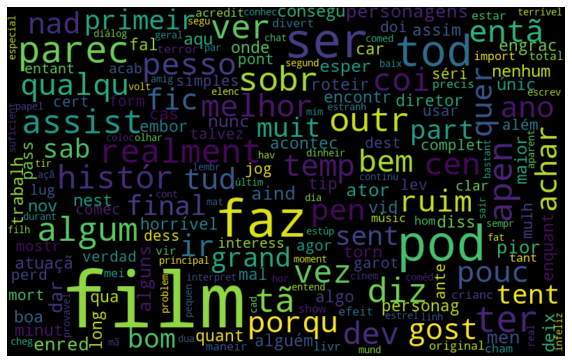

In [31]:
# gerando uma nuvem de palvaras para as resenhas negativas dos dados lematizado e stemetizado
word_cloud_sentiment (df, "text_lemma_e_stemm", "classification" , sentiment = 0)

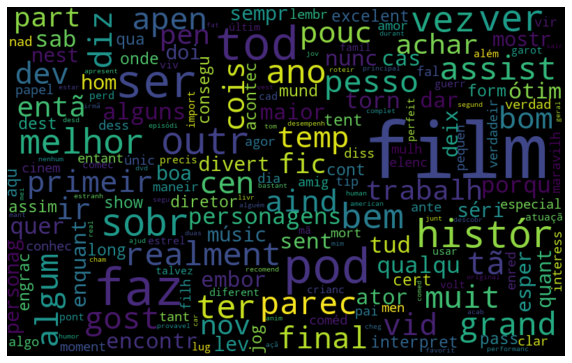

In [32]:
# gerando uma nuvem de palvaras para as resenhas positivas dos dados lematizado e stemetizado
word_cloud_sentiment (df, "text_lemma_e_stemm", "classification" , sentiment = 1)

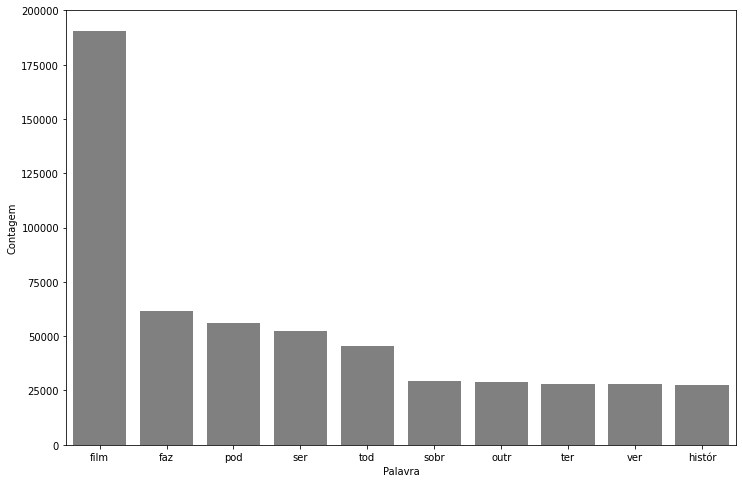

In [40]:
freq_words(df, 'text_lemma_e_stemm', 10)

In [28]:
df.to_csv('clean_data_lemmaANDstemm.csv', index = False)

# Modelagem 

Para a modelagem dos dados irei utilizar tanto uma regressão logistica simples, como um rede neural.
Isso será realizado com o intuito de consolidar melhor os conhecimentos obtidos em aulas.

## Utilizando regressão logística

Para esse modelo irei utilizar o TF-IDF e ngram


In [2]:
df = pd.read_csv('clean_data_lemmaANDstemm.csv')
df.head(1)

,text_pt,classification,text_clean,text_lemma,text_stemm,text_lemma_e_stemm
0,"Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. A maioria de nós tem fantasmas no armário, e o personagem Costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. O personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, Ashton Kutcher. O problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, quando estamos bem além do meio do caminho, Costner nos conta sobre os fantasmas dos Kutchers. Somos informados de por que Kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. Nenhuma mágica aqui, era tudo que eu podia fazer para não desligar uma hora.",0,vez costner arrumou filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importei nenhum personagens maioria fantasmas armário personagem costers realizado logo início esquecido tarde importava personagem deveríamos importar arrogante superconfiante ashton kutcher problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armário desordenado único obstáculo parece estar vencendo costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informados kutcher levado ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo podia fazer desligar hora,vez costner arrumar filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importar nenhum personagens maioria fantasmas armário personagem costers realizar logo início esquecido tarde importar personagem dever importar arrogante superconfiante ashton kutcher problema sair garoto pensar melhor qualquer outra pessoa redor mostrar sinais armário desordenar único obstáculo parecer estar vencer costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informar kutcher levar ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo poder fazer desligar hora,vez costn arrum film temp necessári além terrív sequênc resgat mar qua pouc simples import nenhum personagens maior fantasm armári personag costers realiz log iníci esquec tard import personag dev import arrog superconfi ashton kutch problem sai garot pens melhor qualqu outr pesso redor mostr sin armári desorden únic obstácul parec estar venc costn final bem além mei caminh costn cont sobr fantasm kutchers inform kutch lev ser melhor pressent pressági anterior nenhum mágic aqu tud pod faz deslig hor,vez costn arrum film temp necessári além terrív sequênc resgat mar qua pouc simples import nenhum personagens maior fantasm armári personag costers realiz log iníci esquec tard import personag dev import arrog superconfi ashton kutch problem sair garot pens melhor qualqu outr pesso redor mostr sin armári desorden únic obstácul parec estar venc costn final bem além mei caminh costn cont sobr fantasm kutchers inform kutch lev ser melhor pressent pressági anterior nenhum mágic aqu tud pod faz deslig hor


In [51]:
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import ngrams

In [52]:
tfidf = TfidfVectorizer (ngram_range = (1,2))

In [53]:
tfidf_clean = tfidf.fit_transform(df["text_clean"])
tfidf_lemma = tfidf.fit_transform(df["text_lemma"])
tfidf_stemm = tfidf.fit_transform(df["text_stemm"])
tfidf_lemma_stemm = tfidf.fit_transform(df["text_lemma_e_stemm"])

In [54]:
regressao_logistica = LogisticRegression(solver = "lbfgs",
                                        random_state= 42, 
                                        verbose = 2, n_jobs =-1)

In [60]:
def classification (vetor_tfidf):
    # separando os dados em treino e teste
    train_X, test_X, train_y, test_y = train_test_split (vetor_tfidf, 
                                                         df['classification'],      
                                                         test_size = 0.2,
                                                         random_state = 42,
                                                         shuffle = True, stratify =  df['classification'])

    # treinando no log reg
    regressao_logistica.fit(train_X, train_y)
    acuracia_tfidf = regressao_logistica.score(test_X, test_y)
    print(acuracia_tfidf)

In [61]:
# Reg log para dados limpos
classification (tfidf_clean)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   51.8s finished


0.8852608168216741


In [62]:
# Reg log para dados lematizados
classification (tfidf_lemma)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   53.8s finished


0.8821269712899312


In [63]:
# Reg log para dados stemmetizados
classification (tfidf_stemm)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   49.1s finished


0.8866761019005257


In [64]:
# Reg log para dados lematizados e stemmetizados
classification (tfidf_lemma_stemm)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   38.8s finished


0.884856449656288


Observa-se que independente do tratamento de limpza utilizado, todo tiveram uma acurácia de ~88%.  Isso utilizando somente um algoritimo de classificação "simples"

Espera-se que com a utilização de redes neurais esse valor aumente ainda mais.


**Verificando as palvras mais frequentes para cada uma das classificações de sentimento**

In [68]:
pesos = pd.DataFrame(regressao_logistica.coef_[0].T,
                     index = tfidf.get_feature_names_out())


In [69]:
pesos.nlargest(10,0)

,0
ótim,9.895649
excelent,9.607513
maravilh,7.785233
perfeit,7.328725
incrível,6.476069
favorit,6.340091
divert,5.998883
ador,5.277211
hoj,4.793000
brilhant,4.670007


In [70]:
pesos.nsmallest(10,0)

,0
pior,-12.809511
ruim,-11.321826
horrível,-9.061980
chat,-7.834143
terrível,-7.655463
nad,-7.648022
parec,-6.750340
nenhum,-6.428643
estúp,-5.851339
lix,-5.671284


Verifica-se que dos valores mais frequentes para cada sentimento, são bem caracteristicos com a nossa lingua, como pior, ruim e horrivel  para resenhas negativas e ótimo, excelente e perfeito para resenhas positivas

---------------------

## Utilizando redes neurais

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [3]:
df = pd.read_csv('clean_data_lemmaANDstemm.csv')
df.head(1)

,text_pt,classification,text_clean,text_lemma,text_stemm,text_lemma_e_stemm
0,"Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. A maioria de nós tem fantasmas no armário, e o personagem Costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. O personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, Ashton Kutcher. O problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, quando estamos bem além do meio do caminho, Costner nos conta sobre os fantasmas dos Kutchers. Somos informados de por que Kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. Nenhuma mágica aqui, era tudo que eu podia fazer para não desligar uma hora.",0,vez costner arrumou filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importei nenhum personagens maioria fantasmas armário personagem costers realizado logo início esquecido tarde importava personagem deveríamos importar arrogante superconfiante ashton kutcher problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armário desordenado único obstáculo parece estar vencendo costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informados kutcher levado ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo podia fazer desligar hora,vez costner arrumar filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importar nenhum personagens maioria fantasmas armário personagem costers realizar logo início esquecido tarde importar personagem dever importar arrogante superconfiante ashton kutcher problema sair garoto pensar melhor qualquer outra pessoa redor mostrar sinais armário desordenar único obstáculo parecer estar vencer costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informar kutcher levar ser melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo poder fazer desligar hora,vez costn arrum film temp necessári além terrív sequênc resgat mar qua pouc simples import nenhum personagens maior fantasm armári personag costers realiz log iníci esquec tard import personag dev import arrog superconfi ashton kutch problem sai garot pens melhor qualqu outr pesso redor mostr sin armári desorden únic obstácul parec estar venc costn final bem além mei caminh costn cont sobr fantasm kutchers inform kutch lev ser melhor pressent pressági anterior nenhum mágic aqu tud pod faz deslig hor,vez costn arrum film temp necessári além terrív sequênc resgat mar qua pouc simples import nenhum personagens maior fantasm armári personag costers realiz log iníci esquec tard import personag dev import arrog superconfi ashton kutch problem sair garot pens melhor qualqu outr pesso redor mostr sin armári desorden únic obstácul parec estar venc costn final bem além mei caminh costn cont sobr fantasm kutchers inform kutch lev ser melhor pressent pressági anterior nenhum mágic aqu tud pod faz deslig hor


In [4]:
train_X, test_X = train_test_split (df, test_size = 0.2, random_state = 42)

In [5]:
def token_keras (df_text_col):
    
    tokenizer = Tokenizer()
    
    # criando um índice do vocabulário com base na frequência das palavras
    tokenizer.fit_on_texts(df_text_col)
    
    # encontrando o comprimento do vetor feito
    word_index = tokenizer.word_index
    
    # determinando o tamanho do vocabulário ( +1 = oov)
    vocab_size = len(word_index) + 1
    
    return vocab_size

In [6]:
vocab_size_clean = token_keras(train_X.text_clean)
vocab_size_lemma = token_keras(train_X.text_lemma)
vocab_size_stemm = token_keras(train_X.text_stemm)
vocab_size_lemma_stemm = token_keras(train_X.text_lemma_e_stemm)

In [7]:
print ("text_clean: ", vocab_size_clean,
       "\ntext_lemma: ", vocab_size_lemma,
       "\ntext_stemm: ", vocab_size_stemm, 
       "\ntext_lemma_e_stemm: ", vocab_size_lemma_stemm )

text_clean:  117010 
text_lemma:  101547 
text_stemm:  69381 
text_lemma_e_stemm:  69014


In [8]:
# encontrando a resenha de maior tamanho

def max_size (df_text_col):
    lista_sizes =[]
    for resenha in df_text_col:
        # fazer split
        size = len (resenha.split())
        lista_sizes.append(size)
    return max(lista_sizes)  


In [9]:
text_clean_size = max_size(df["text_clean"])
text_lemma_size = max_size(df["text_lemma"])
text_stemm_size = max_size(df["text_stemm"])
text_lemma_e_stemm_size = max_size(df["text_lemma_e_stemm"])


print ("text_clean: ", text_clean_size)
print ("text_lemma: ", text_lemma_size)
print ("text_stemm: ", text_stemm_size)
print ("text_lemma_e_stemm: ", text_lemma_e_stemm_size)

text_clean:  526
text_lemma:  526
text_stemm:  526
text_lemma_e_stemm:  526


In [10]:
# dados Y
train_y = train_X.classification.tolist()
train_y = np.reshape(train_y, (-1, 1)) 

test_y = test_X.classification.tolist()
test_y  = np.reshape(test_y, (-1, 1)) 

In [11]:
# dados X -> fazendo o padding das sequencias

tokenizer = Tokenizer()

# text_clean
trainX_C = pad_sequences(tokenizer.texts_to_sequences(train_X.text_clean), maxlen=text_clean_size)
testX_C = pad_sequences(tokenizer.texts_to_sequences(test_X.text_clean), maxlen=text_clean_size)

# text_lemma
trainX_L = pad_sequences(tokenizer.texts_to_sequences(train_X.text_lemma), maxlen=text_lemma_size)
testX_L = pad_sequences(tokenizer.texts_to_sequences(test_X.text_lemma), maxlen=text_lemma_size)

# text_stemm
trainX_S = pad_sequences(tokenizer.texts_to_sequences(train_X.text_stemm), maxlen=text_stemm_size)
testX_S = pad_sequences(tokenizer.texts_to_sequences(test_X.text_stemm), maxlen=text_stemm_size)

# text_lemma + stem
trainX_LS = pad_sequences(tokenizer.texts_to_sequences(train_X.text_lemma_e_stemm), maxlen=text_lemma_e_stemm_size)
testX_LS = pad_sequences(tokenizer.texts_to_sequences(test_X.text_lemma_e_stemm), maxlen= text_lemma_e_stemm_size)

In [12]:
print ("text_clean: ", trainX_C.shape )
print ("text_lemma: ", trainX_L.shape )
print ("text_stemm: ",  trainX_S.shape)
print ("text_lemma_e_stemm: ", trainX_LS.shape )

print ("teste shape: ", train_y.shape, test_y.shape)

text_clean:  (39567, 526)
text_lemma:  (39567, 526)
text_stemm:  (39567, 526)
text_lemma_e_stemm:  (39567, 526)
teste shape:  (39567, 1) (9892, 1)


### Treinando o Embeding

In [13]:
from keras.layers import Embedding, Input, Dropout, LSTM, Dense, SpatialDropout1D
import tensorflow as tf
from keras.layers import Conv1D, Bidirectional

#### Clean text

In [14]:
embedding_layer_C = Embedding(input_dim = vocab_size_clean, 
                            output_dim = 400, 
                            input_length = text_clean_size)

In [15]:
sequence_input = Input(shape=(text_clean_size), dtype = 'int32')
embedding_sequences = embedding_layer_C(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation = 'relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# juntando o modelo
model_C = tf.keras.Model(sequence_input, outputs)

In [16]:
model_C.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 526)]             0         
                                                                 
 embedding (Embedding)       (None, 526, 400)          46804000  
                                                                 
 spatial_dropout1d (SpatialD  (None, 526, 400)         0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 522, 64)           128064    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0     

In [17]:
model_C.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
BATCH_SIZE = 512
EPOCHS = 10
history_1 = model_C.fit(trainX_C, train_y, batch_size=BATCH_SIZE, epochs = EPOCHS, validation_data = (testX_C, test_y))

Epoch 1/10
78/78 [==============================] - 2953s 38s/step - loss: 0.6935 - accuracy: 0.4978 - val_loss: 0.6930 - val_accuracy: 0.5093
Epoch 2/10
78/78 [==============================] - 4686s 60s/step - loss: 0.6933 - accuracy: 0.5004 - val_loss: 0.6934 - val_accuracy: 0.4907
Epoch 3/10
78/78 [==============================] - 5290s 68s/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6930 - val_accuracy: 0.5093
Epoch 4/10
78/78 [==============================] - 5491s 70s/step - loss: 0.6933 - accuracy: 0.4998 - val_loss: 0.6933 - val_accuracy: 0.4907
Epoch 5/10
78/78 [==============================] - 5536s 71s/step - loss: 0.6933 - accuracy: 0.5014 - val_loss: 0.6936 - val_accuracy: 0.4907
Epoch 6/10
78/78 [==============================] - 5553s 71s/step - loss: 0.6933 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.4907
Epoch 7/10
78/78 [==============================] - 5448s 70s/step - loss: 0.6933 - accuracy: 0.4968 - val_loss: 0.6934 - val_accuracy: 0.4907

In [19]:
# salvando o modelo clean_text
model_C.save("clean_model.h5")

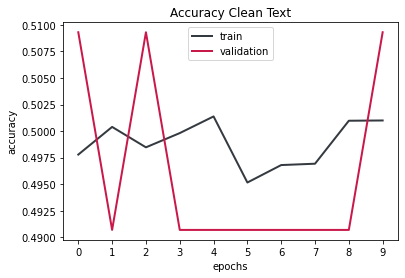

In [20]:
plt.title('Accuracy Clean Text')
plt.plot(history_1.history['accuracy'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_1.history['val_accuracy'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, EPOCHS)))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

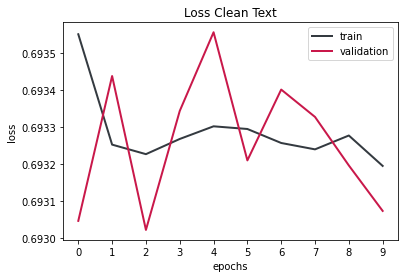

In [21]:
plt.title('Loss Clean Text')
plt.plot(history_1.history['loss'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_1.history['val_loss'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, EPOCHS)))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [22]:
# verificando como modelo se sairia na prática 
pred_clean = model_C.predict(testX_C)

In [23]:
pred_clean

array([[0.4977405],
       [0.4977405],
       [0.4977405],
       ...,
       [0.4977405],
       [0.4977405],
       [0.4977405]], dtype=float32)

In [30]:
y_pred = np.where(pred_clean < 0.5, 0, 1)

print (classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67      5038
           1       0.00      0.00      0.00      4854

    accuracy                           0.51      9892
   macro avg       0.25      0.50      0.34      9892
weighted avg       0.26      0.51      0.34      9892



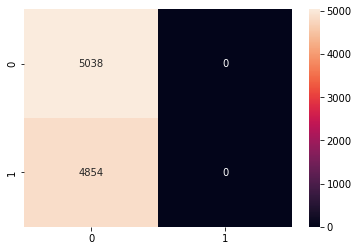

In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

#### Lemma text

In [14]:
embedding_layer_L = Embedding(input_dim = vocab_size_lemma, 
                            output_dim = 400, 
                            input_length = text_lemma_size)

In [15]:
sequence_input = Input(shape=(text_lemma_size), dtype = 'int32')
embedding_sequences = embedding_layer_L(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation = 'relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# juntando o modelo
model_L = tf.keras.Model(sequence_input, outputs)

In [16]:
model_L.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 526)]             0         
                                                                 
 embedding (Embedding)       (None, 526, 400)          40618800  
                                                                 
 spatial_dropout1d (SpatialD  (None, 526, 400)         0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 522, 64)           128064    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0     

In [17]:
model_L.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
# treino com dados lematizados 
BATCH_SIZE = 512
EPOCHS = 10
history_2 = model_L.fit(trainX_L, train_y, batch_size=BATCH_SIZE, epochs = EPOCHS, validation_data = (testX_L, test_y))

Epoch 1/10
78/78 [==============================] - 2985s 39s/step - loss: 0.6936 - accuracy: 0.4976 - val_loss: 0.6937 - val_accuracy: 0.4907
Epoch 2/10
78/78 [==============================] - 4763s 61s/step - loss: 0.6933 - accuracy: 0.5013 - val_loss: 0.6933 - val_accuracy: 0.4907
Epoch 3/10
78/78 [==============================] - 5361s 69s/step - loss: 0.6933 - accuracy: 0.5007 - val_loss: 0.6933 - val_accuracy: 0.4907
Epoch 4/10
78/78 [==============================] - 5497s 71s/step - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6931 - val_accuracy: 0.5093
Epoch 5/10
78/78 [==============================] - 5535s 71s/step - loss: 0.6933 - accuracy: 0.4997 - val_loss: 0.6933 - val_accuracy: 0.4907
Epoch 6/10
78/78 [==============================] - 5547s 71s/step - loss: 0.6934 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5093
Epoch 7/10
78/78 [==============================] - 5532s 71s/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5093

In [19]:
# salvando o modelo lemma
model_L.save("lemma_model.h5")

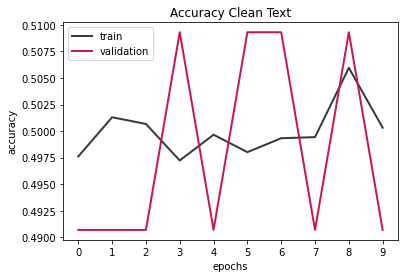

In [20]:
plt.title('Accuracy Clean Text')
plt.plot(history_2.history['accuracy'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_2.history['val_accuracy'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, EPOCHS)))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

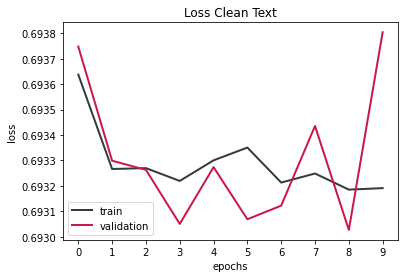

In [21]:
plt.title('Loss Clean Text')
plt.plot(history_2.history['loss'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_2.history['val_loss'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, EPOCHS)))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
# verificando como modelo se sairia na prática 
pred_lemma = model_L.predict(testX_L)
pred_lemma

array([[0.5110752],
       [0.5110752],
       [0.5110752],
       ...,
       [0.5110752],
       [0.5110752],
       [0.5110752]], dtype=float32)

In [24]:
y_pred = np.where(pred_lemma < 0.5, 0, 1)

print (classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5038
           1       0.49      1.00      0.66      4854

    accuracy                           0.49      9892
   macro avg       0.25      0.50      0.33      9892
weighted avg       0.24      0.49      0.32      9892



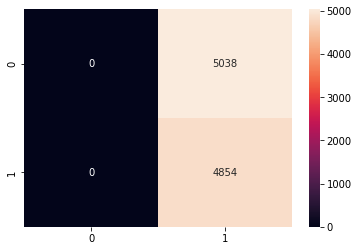

In [25]:
cm = confusion_matrix(test_y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

#### Stemm text

In [26]:
embedding_layer_S = Embedding(input_dim = vocab_size_stemm, 
                            output_dim = 400, 
                            input_length = text_stemm_size)

In [27]:
sequence_input = Input(shape=(text_stemm_size), dtype = 'int32')
embedding_sequences = embedding_layer_S(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 3, activation = 'relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# juntando o modelo
model_S = tf.keras.Model(sequence_input, outputs)

In [28]:
model_S.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 526)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 526, 400)          27752400  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 526, 400)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 524, 64)           76864     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0   

In [29]:
model_S.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [30]:
# treino com dados stemetizados 
BATCH_SIZE = 512
EPOCHS = 10
history_3 = model_S.fit(trainX_S, train_y, batch_size=BATCH_SIZE, epochs = EPOCHS, validation_data = (testX_S, test_y) )

Epoch 1/10
78/78 [==============================] - 5101s 65s/step - loss: 0.6936 - accuracy: 0.4957 - val_loss: 0.6931 - val_accuracy: 0.5093
Epoch 2/10
78/78 [==============================] - 5184s 67s/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5093
Epoch 3/10
78/78 [==============================] - 5212s 67s/step - loss: 0.6934 - accuracy: 0.4983 - val_loss: 0.6930 - val_accuracy: 0.5093
Epoch 4/10
78/78 [==============================] - 5187s 67s/step - loss: 0.6933 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy: 0.4907
Epoch 5/10
78/78 [==============================] - 5203s 67s/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5093
Epoch 6/10
78/78 [==============================] - 5233s 67s/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.4907
Epoch 7/10
78/78 [==============================] - 5234s 67s/step - loss: 0.6933 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4907

In [31]:
# salvando o modelo stemm
model_S.save("stemm_model.h5")

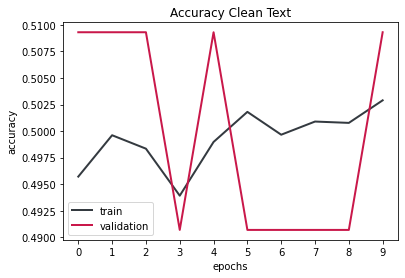

In [32]:
plt.title('Accuracy Clean Text')
plt.plot(history_3.history['accuracy'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_3.history['val_accuracy'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, EPOCHS)))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

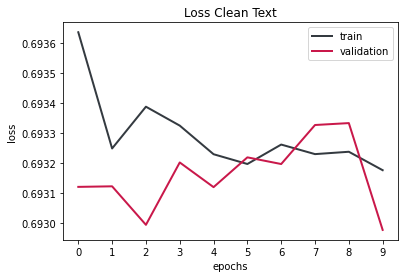

In [33]:
plt.title('Loss Clean Text')
plt.plot(history_3.history['loss'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_3.history['val_loss'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, EPOCHS)))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [34]:
# verificando como modelo se sairia na prática 
pred_stemm = model_S.predict(testX_S)
pred_stemm

array([[0.49173453],
       [0.49173453],
       [0.49173453],
       ...,
       [0.49173453],
       [0.49173453],
       [0.49173453]], dtype=float32)

In [35]:
y_pred = np.where(pred_stemm < 0.5, 0, 1)

print (classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67      5038
           1       0.00      0.00      0.00      4854

    accuracy                           0.51      9892
   macro avg       0.25      0.50      0.34      9892
weighted avg       0.26      0.51      0.34      9892



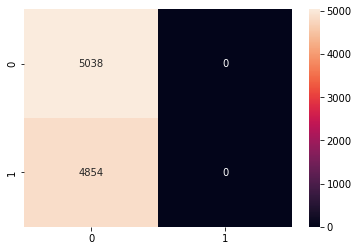

In [36]:
cm = confusion_matrix(test_y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

#### Lemma + Stemm text

In [37]:
embedding_layer_LS = Embedding(input_dim = vocab_size_lemma_stemm, 
                            output_dim = 400, 
                            input_length = text_lemma_e_stemm_size)

In [38]:
sequence_input = Input(shape=(text_lemma_e_stemm_size), dtype = 'int32')
embedding_sequences = embedding_layer_LS(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 3, activation = 'relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# juntando o modelo
model_LS = tf.keras.Model(sequence_input, outputs)

In [39]:
model_LS.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 526)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 526, 400)          27605600  
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 526, 400)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 524, 64)           76864     
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128)               0   

In [40]:
model_LS.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [41]:
# treino com dados lemma +stemm 
BATCH_SIZE = 512
EPOCHS = 10
history_4 = model_LS.fit(trainX_LS, train_y, batch_size=BATCH_SIZE, epochs = EPOCHS, validation_data = (testX_LS, test_y))

Epoch 1/10
78/78 [==============================] - 5426s 70s/step - loss: 0.6935 - accuracy: 0.5007 - val_loss: 0.6930 - val_accuracy: 0.5093
Epoch 2/10
78/78 [==============================] - 5481s 70s/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6936 - val_accuracy: 0.4907
Epoch 3/10
78/78 [==============================] - 5497s 71s/step - loss: 0.6934 - accuracy: 0.4977 - val_loss: 0.6935 - val_accuracy: 0.4907
Epoch 4/10
78/78 [==============================] - 5507s 71s/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6932 - val_accuracy: 0.4907
Epoch 5/10
78/78 [==============================] - 5524s 71s/step - loss: 0.6933 - accuracy: 0.4978 - val_loss: 0.6930 - val_accuracy: 0.5093
Epoch 6/10
78/78 [==============================] - 5518s 71s/step - loss: 0.6933 - accuracy: 0.4968 - val_loss: 0.6930 - val_accuracy: 0.5093
Epoch 7/10
78/78 [==============================] - 5499s 71s/step - loss: 0.6933 - accuracy: 0.4966 - val_loss: 0.6933 - val_accuracy: 0.4907

In [42]:
# salvando o modelo lemma +stemm 
model_LS.save("LS_model.h5")

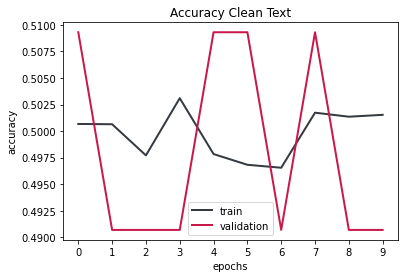

In [43]:
plt.title('Accuracy Clean Text')
plt.plot(history_4.history['accuracy'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_4.history['val_accuracy'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, EPOCHS)))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

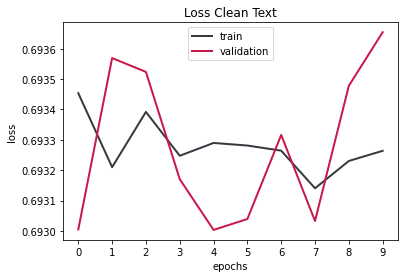

In [44]:
plt.title('Loss Clean Text')
plt.plot(history_4.history['loss'], label = 'train', color = '#343A40', linewidth = 2.0)
plt.plot(history_4.history['val_loss'], label = 'validation', color = '#C9184A', linewidth = 2.0)
plt.xticks(list(range(0, EPOCHS)))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [45]:
# verificando como modelo se sairia na prática 
pred_LS = model_LS.predict(testX_LS)
pred_LS

array([[0.50913966],
       [0.50913966],
       [0.50913966],
       ...,
       [0.50913966],
       [0.50913966],
       [0.50913966]], dtype=float32)

In [46]:
y_pred = np.where(pred_LS < 0.5, 0, 1)

print (classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5038
           1       0.49      1.00      0.66      4854

    accuracy                           0.49      9892
   macro avg       0.25      0.50      0.33      9892
weighted avg       0.24      0.49      0.32      9892



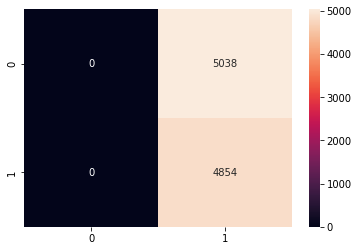

In [47]:
cm = confusion_matrix(test_y, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

Infelizmente a utilização de redes neurais não mostrou a melhorra esperado, entretanto para um trabalho futuro a intensão é utilizar um embedding treinado, como GLOOVE600